- Comp47350 - Data Analytics
- 
- Homework2
- 
- This Report focuses on training and evaluating prediction models for a particular problem and dataset. In this analysis, we focus on using data collected by CDC to build a data analytics solution for death risk prediction.
- The goal of this report is to work with CDC data to build and evaluate prediction models that capture the relationship between the Independent Variables and the target feature **death_yn**

- The Covid-19 pandemic caused widespread health and economic issues, primarily from 2020 until 2022. The Centre for Disease Control (CDC) in the USA has made public their Covid-19 data. The CDC database contains 105 million entries. From this, 50,000 datapoints were randomly selected for data analysis, with 19 features describing the data. The outcome for the target feature “death_yn” is known (i.e., either “yes” or “no”). The CDC dataset was in CSV format, and was parsed with Python 3.11.7 code. 
- 
- Each entry represents a different person, including information such as state and county of residence, age group, sex, race and whether the patient died as a result of illness, among others.
- 
- The dataset has been cleaned elsewhere. Of the original 19 features, 8 remain: case_month, res_state, age_group, sex, race, ethnicity, hosp_yn, and the target feature death_yn. Feature county_fips_code was transformed into county_frequency_size, and 3 additional features were created for the dataset: party, Profile, and seasons. The dataset, "new_features_df1.csv" contains 11 independent variables and the dependent variable, death_yn.

In [530]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

import numpy as np
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [531]:
df = pd.read_csv(r"C:\Users\35385\Desktop\CS_Spring2024\DataAnal\Homework2\new_features_df1.csv", keep_default_na=True, delimiter=",", skipinitialspace=True, encoding="Windows-1252")
#Information from "Profile" is contained in other features. It was created for the previous assignment to find key demographs, but will interfere with accurate modelling in this assignment (potential multicolinnearity)
#same for "season" and case_month, and case_month will be dropped
df.drop(columns=["Profile", "case_month"], inplace=True)

In [532]:
# Convert all object-type columns to categorical type
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39947 entries, 0 to 39946
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   res_state              39947 non-null  category
 1   age_group              39947 non-null  category
 2   sex                    39947 non-null  category
 3   race                   39947 non-null  category
 4   ethnicity              39947 non-null  category
 5   hosp_yn                39947 non-null  category
 6   death_yn               39947 non-null  category
 7   county_frequency_size  39947 non-null  category
 8   party                  39947 non-null  category
 9   seasons                39947 non-null  category
dtypes: category(10)
memory usage: 393.1 KB


In [533]:
df.head(10)

,res_state,age_group,sex,race,ethnicity,hosp_yn,death_yn,county_frequency_size,party,seasons
0,CA,65+ years,_M,White,Non_H/L,Yes,Yes,Medium,DEMOCRAT,Spring
1,NY,65+ years,_F,White,Non_H/L,Yes,Yes,Medium,DEMOCRAT,Spring
2,FL,65+ years,_F,White,Non_H/L,No,Yes,Medium,DEMOCRAT,Fall
3,TX,50 to 64 years,_M,White,H/L,Yes,Yes,Very_Large,DEMOCRAT,Summer
4,AZ,65+ years,_M,White,H/L,Yes,Yes,Small,DEMOCRAT,Winter
5,WI,65+ years,_F,White,Non_H/L,Yes,Yes,Medium,REPUBLICAN,Fall
6,MD,65+ years,_F,White,Non_H/L,No,Yes,Small,DEMOCRAT,Spring
7,MN,65+ years,_M,White,Non_H/L,No,Yes,Small,DEMOCRAT,Fall
8,NY,65+ years,_M,White,Non_H/L,No,Yes,Huge,DEMOCRAT,Winter
9,NY,65+ years,_F,White,Non_H/L,No,Yes,Huge,DEMOCRAT,Spring


Frequency Table printed to better understand the dataset.

In [534]:
for column in df.columns:
    print(f"Frequency table for column '{column}':")
    print(df[column].value_counts())
    print("\n")

Frequency table for column 'res_state':
res_state
NY    5301
NC    3759
NJ    3627
FL    3503
OH    2156
TX    2063
IN    2038
MN    2031
CA    1457
MD    1404
AZ    1113
MI    1109
KY     823
PA     785
KS     777
WI     650
VA     647
NV     618
OR     607
SC     599
UT     547
MA     538
IL     437
TN     394
OK     388
ID     301
CO     282
ME     280
DC     274
AL     206
AR     195
RI     161
MT     119
CT     115
WA     114
NH     109
MO      98
NM      76
VT      68
IA      65
LA      50
WY      23
GA      14
MS      13
ND       8
NE       3
AK       2
Name: count, dtype: int64


Frequency table for column 'age_group':
age_group
18 to 49 years    16343
65+ years         11647
50 to 64 years     6657
0 - 17 years       5300
Name: count, dtype: int64


Frequency table for column 'sex':
sex
_F    21144
_M    18803
Name: count, dtype: int64


Frequency table for column 'race':
race
White                                     34049
Black                                      4536
Asian

- **Data Understanding and Preparation:**
- 
- The following section explores the relationships between feature pairs, followed by selecting/transforming promising features based on a given training set.
- 
- The dataframe is divided in two: a 70% training set and 30% test set. The test set will be used later for analysis,
- 
- The features in the training set are then plotted for their pairwise interactions with the target feature. Only values with a count of greater than 200 for a given feature are plotted, for ease of legibility in the graphs, especially for res_state and Profile features

- A subset of categorical features which look promising will be chosen for in-depth discussion and analysis. These will be features where it appears that there is a significant variance across the feature for predicting the target outcome, features for which there appears to be a trend for predicting death_yn etc.

In [535]:
X = df.drop(columns=['death_yn'])
y = df['death_yn']

# Split dataset into training and test sets; random_state ensuring the same test/ training datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

print("Training data:\n", pd.concat([X_train, y_train], axis=1))
print("\nTest data:\n", pd.concat([X_test, y_test], axis=1))

Training data:
       res_state       age_group sex   race ethnicity hosp_yn  \
36228        IN  50 to 64 years  _M  White   Non_H/L      No   
11671        OR  50 to 64 years  _M  White   Non_H/L      No   
12993        KY       65+ years  _M  White   Non_H/L      No   
17552        MI  50 to 64 years  _M  White   Non_H/L      No   
4017         WA       65+ years  _F  White   Non_H/L      No   
...         ...             ...  ..    ...       ...     ...   
7813         MN       65+ years  _F  White   Non_H/L     Yes   
32511        UT  18 to 49 years  _F  White   Non_H/L      No   
5192         AZ       65+ years  _F  White   Non_H/L     Yes   
12172        NC  18 to 49 years  _M  White   Non_H/L      No   
33003        NY  18 to 49 years  _F  White   Non_H/L      No   

      county_frequency_size       party seasons death_yn  
36228            Very_Small  REPUBLICAN  Winter       No  
11671                 Small    DEMOCRAT  Winter       No  
12993                Medium  REPUBLICA

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


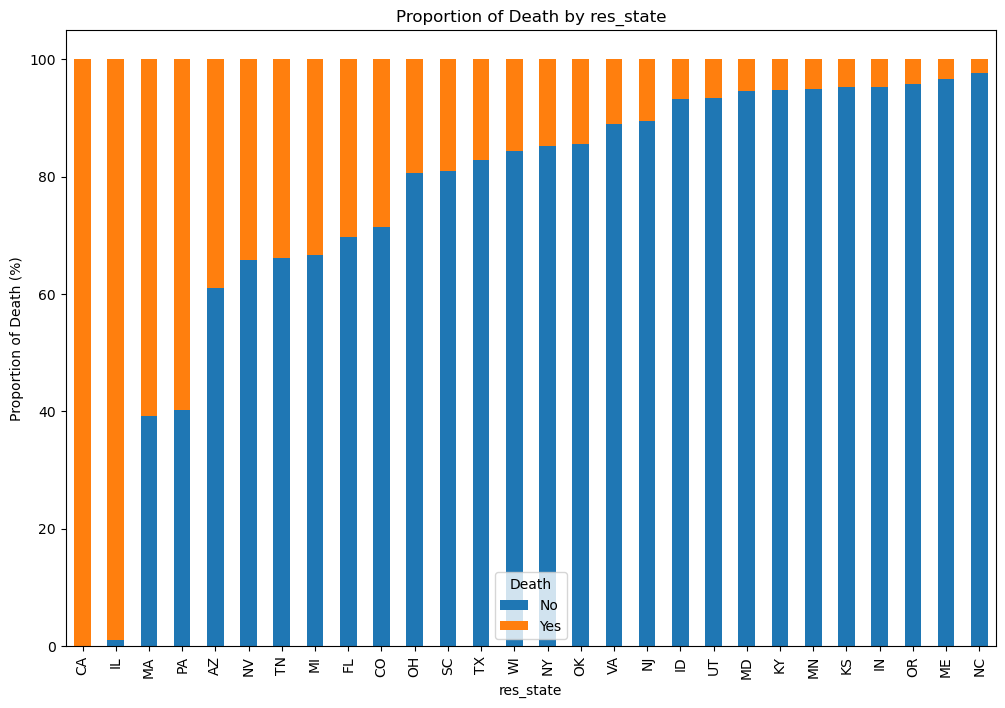

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


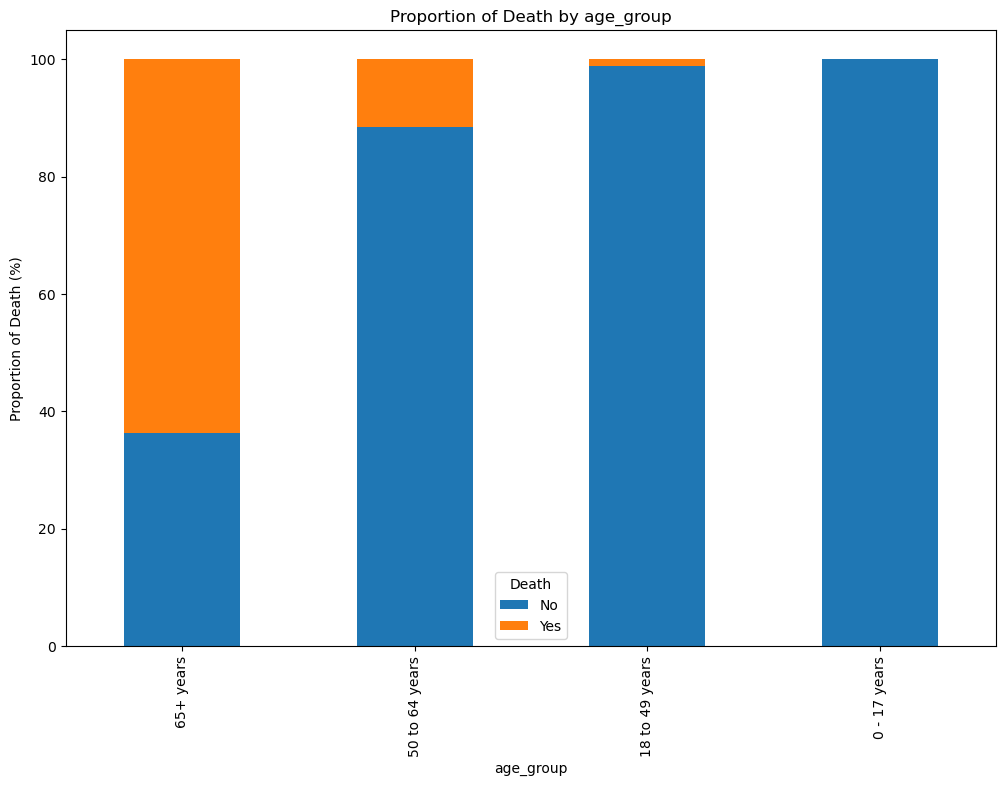

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


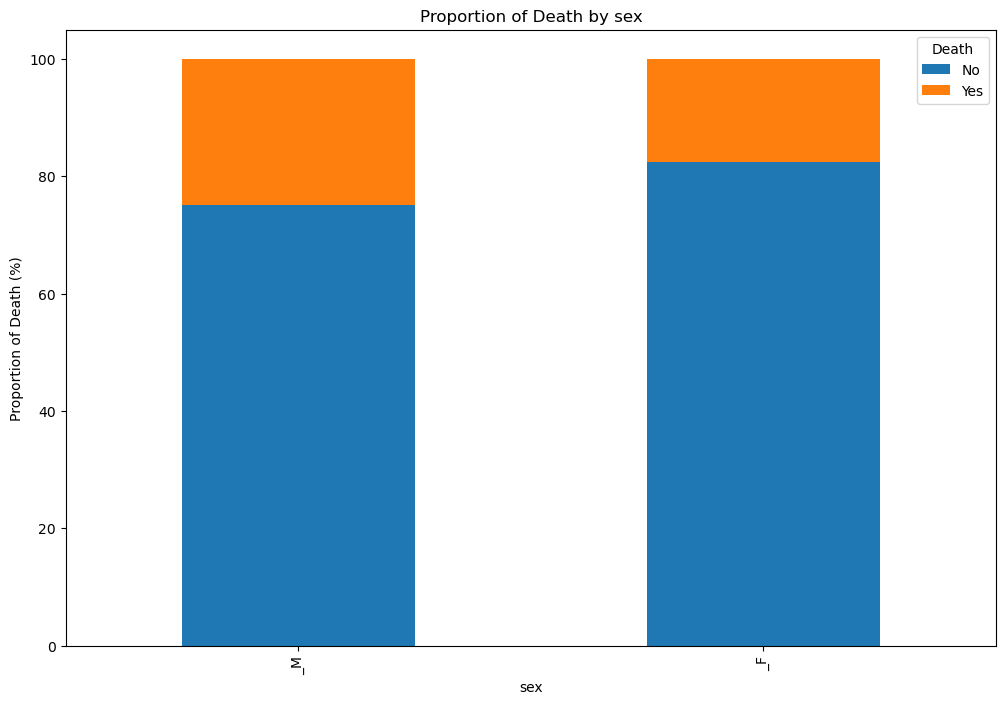

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


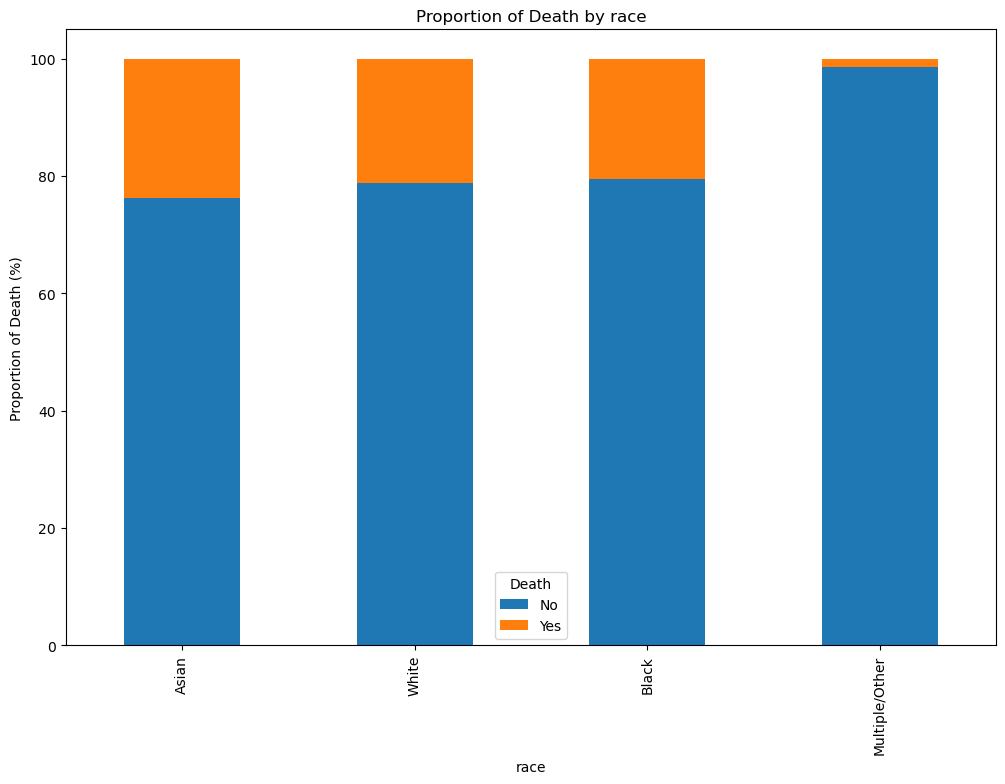

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


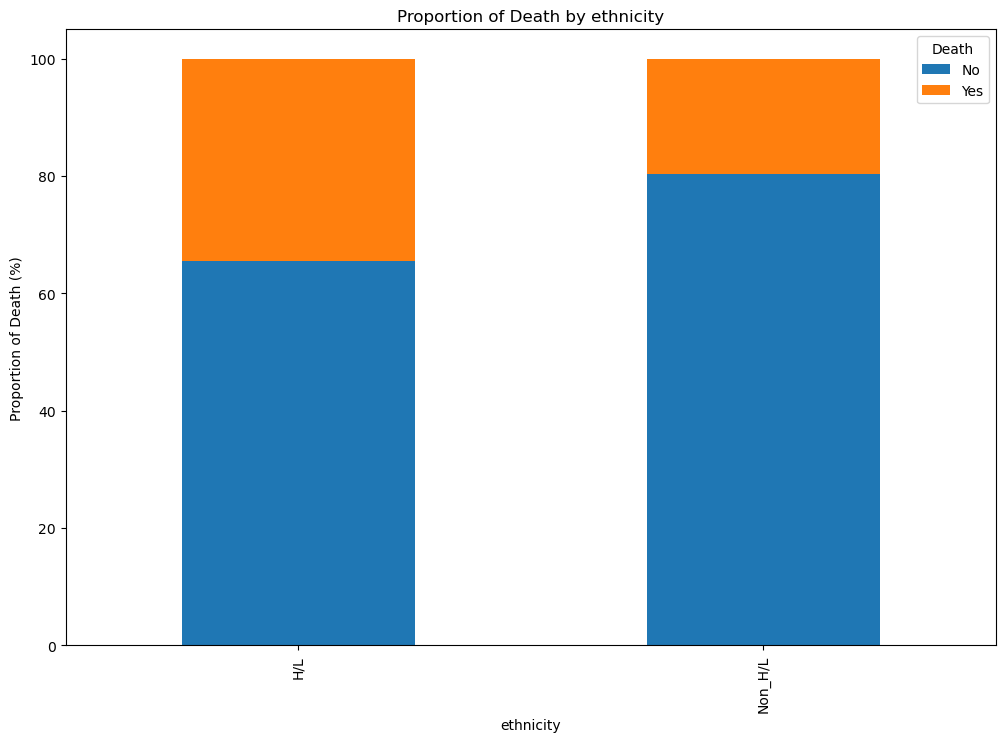

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


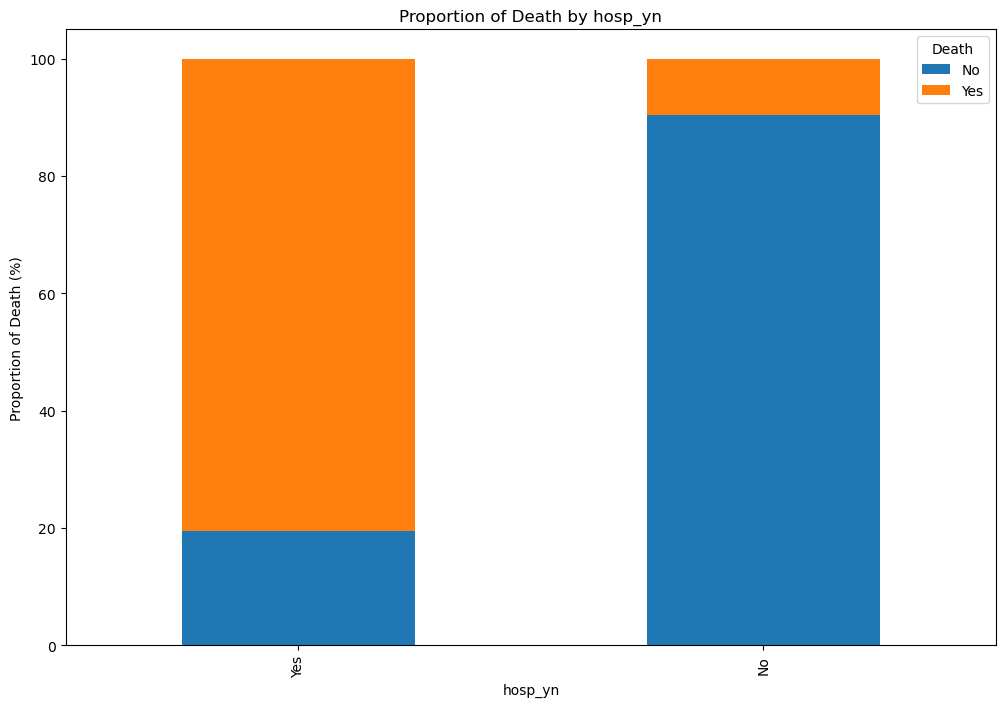

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


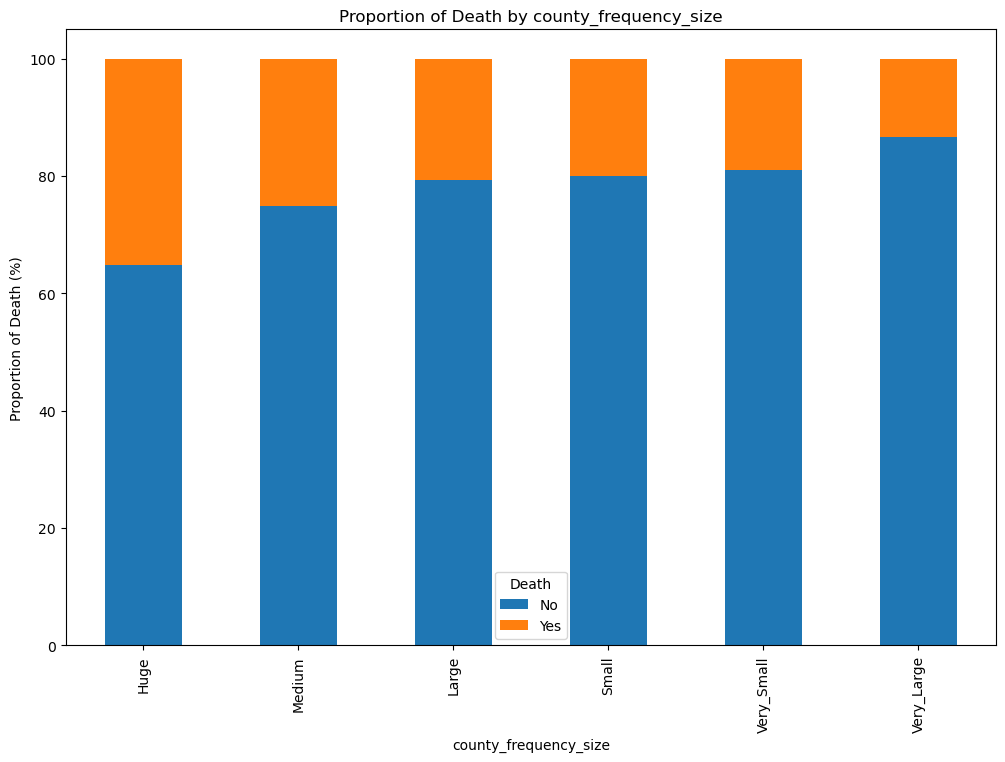

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


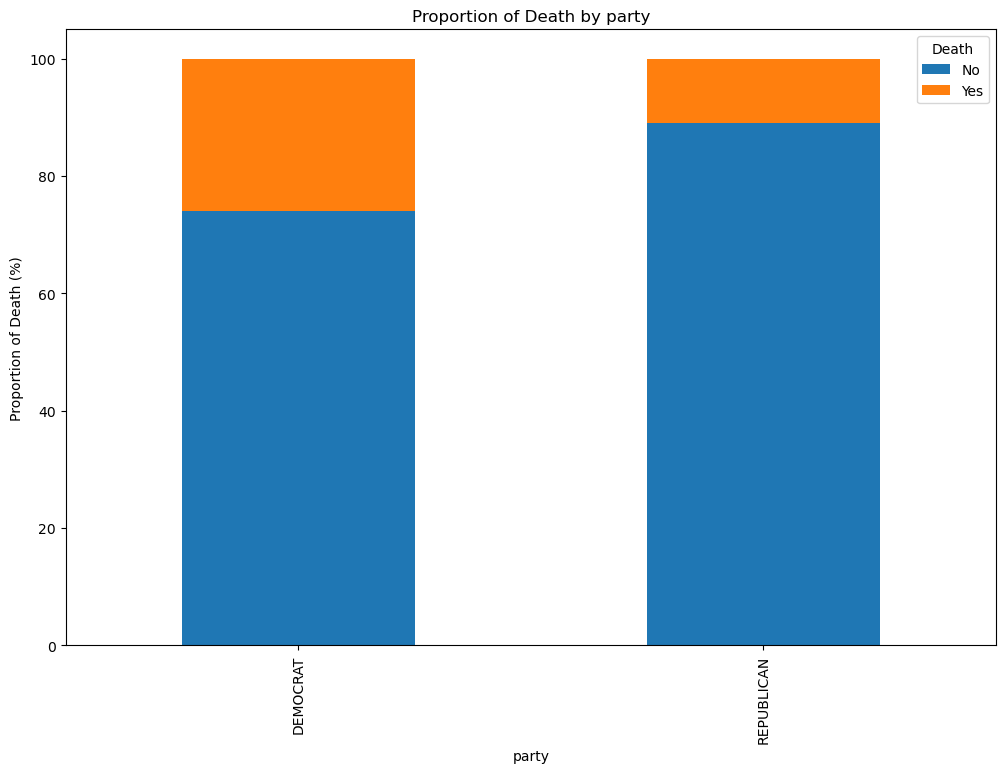

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\1925401047.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)


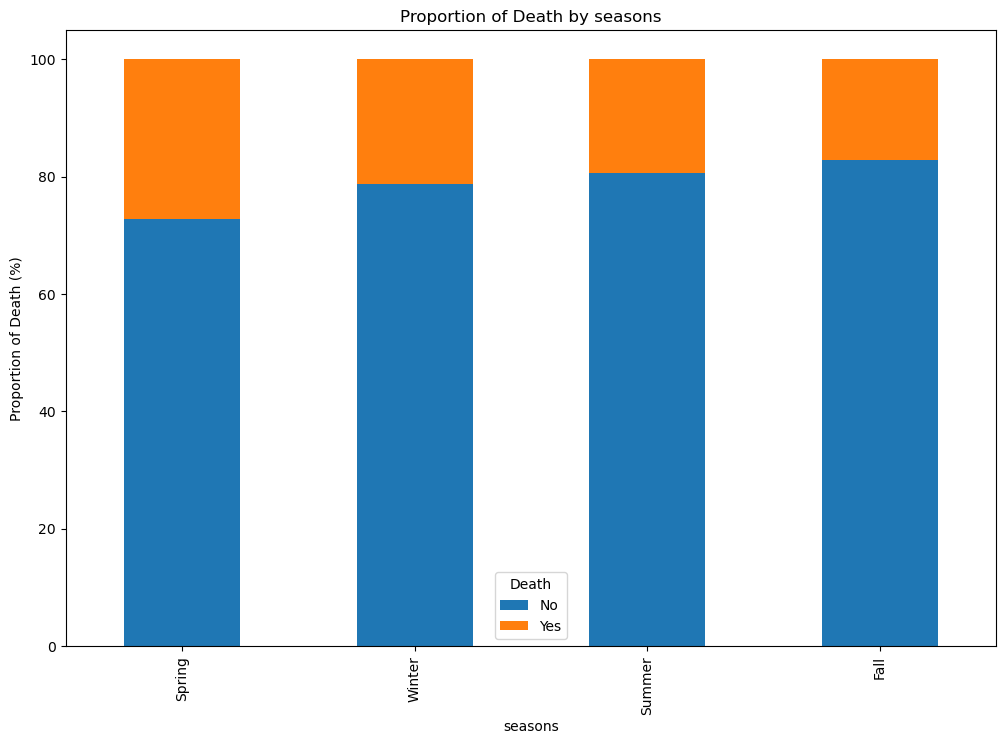

In [536]:
train_data = pd.concat([X_train, y_train], axis=1)


def plot_proportion_of_death(input, feature):
    # Calculate overall counts for each value in the feature
    overall_counts = input[feature].value_counts()

    # Filter features where overall count for any value is greater than 200: allows for better graphing
    valid_features = overall_counts[overall_counts > 200].index.tolist()

    # Check if the feature has enough valid values (>200 for plotting)
    if len(valid_features) == 0:
        print(f"No values in feature '{feature}' have overall count greater than 200.")
        return

    # Calculate counts of "Yes" and "No" for each feature
    death_counts = input.groupby(feature)['death_yn'].value_counts().unstack(fill_value=0)

    # Filter out only the valid values in the feature
    death_counts = death_counts.loc[valid_features]

    # Calculate proportion of death per feature category
    proportion_death_feature = death_counts.div(death_counts.sum(axis=1), axis=0) * 100

    # Sort based on highest death "Yes" proportion
    sorted_feature = proportion_death_feature.sort_values(by="Yes", ascending=False)

    sorted_feature.plot(kind="bar", stacked=True, figsize=(12, 8))
    plt.title(f"Proportion of Death by {feature}")
    plt.ylabel("Proportion of Death (%)")
    plt.xlabel(feature)
    plt.legend(title="Death")
    # plt.xticks(rotation=45)
    plt.show()

for column in X_train.columns:
    plot_proportion_of_death(train_data, column)

 - **Discussion of subset of above pairwise interactions between plots:**

- The graphs above contain plots where values for the categories have a count of 200+. This is done in order to improve the legibility of the plots.
- In advance of the discussion that follows, it should be noted that there are 39,947 rows of data, and it seems likely that if statistical analyses such as t-tests or chi-squared are performed that p-values could be significant for each of the features in predicting death_yn.
- In addition to this, nationwide, the CDC database of the USA has 105,000,000 cases of Covid-19, and a death count of 1,143,724 as of late 2023 (https://www.cdc.gov/nchs/covid19/mortality-overview.htm). This means that Covid-19 has a rough mortality of 1.089% of those who contracted it, and this is a similar rate to that reported by the WHO (0.91%) (https://data.who.int/dashboards/covid19/cases?n=c). Given this data, features with frequencies which appear to be higher or lower than this rate could be good predictors for the target variable.
- 
- However, from the plots above age_group and hosp_yn show clear trends, and res_state shows a wide variance, and these seem promising for predicting death_yn.
- 
- **age_group**: The plotted pairwise interaction for age_group confirms suspicions that people 65+ years of age are most at risk of dying from Covid-19, and those aged 0-17 have what appears to be a near total survival rate. Additionally, the trend is present for all 4 values of age_group, 0-17 years, 18-49 years, 50-64 years, and 65+ years. The younger the person is, the more likely they are to survive, possibly due to the robustness of a child's immune system and conversely, older poeple are more susceptible to fatal illness.
- 
- **res_state**: This feature shows a wide degree of outcomes for the target variable. The graph shows 28 states, and there seems to be a roughly 95% variance for predicting the target outcome between the individual States. This appearance should not be chalked down to possible sampling issues, where states with small counts appear to have near 100% survival or fatality rates. On the contrary, the state with the highest death rate is the most populous, California, and the state with the highest survival rate is North Carolina, the 9th largest state in the USA.
- 
- **hosp_yn**: The stacked bar plot of hosp_yn appears to show the most variance and so could be a strong candidate for being able to predict death_yn. Importantly, this feature is a simple boolean, "Was Hospitalised" or "Was Not Hospitalised", and this has the advantages of reduced dimensionality and simplicity. The plot shows that people who were hospitalised are far more likely to pass away as a reuslt of contracting Covid-19. If a patient is hospitalised with Covid-19, their health status is likely to be worse and require treatment, whereas mostly unaffected people have no need of healthcare intervention.

    - (2.1) On the training set, train a linear regression model to predict the target feature, using only the  descriptive features selected in exercise (1) above. 

In [537]:
def one_hot_encode(df):
    encoded_df = pd.get_dummies(df)
    return encoded_df

X_train_encoded = one_hot_encode(X_train)

In [538]:
def perform_linear_regression(X_train, y_train):
    model = LinearRegression()
    model.fit(X_train, y_train)
    return model

In [539]:
def fit_one_hot_encoder(data):
    # OneHotEncoder object
    onehot_encoder = OneHotEncoder(sparse=False, dtype=int)
    onehot_encoder.fit(data)
    return onehot_encoder

def transform_one_hot_encoder(data, encoder):
    # Transform data using the provided encoder
    X_encoded = encoder.transform(data)
    return X_encoded

# Fit the OneHotEncoder on training data
onehot_encoder = fit_one_hot_encoder(X_train)

# Transform the training data using the fitted encoder
X_train_encode = transform_one_hot_encoder(X_train, onehot_encoder)

c:\Users\35385\anaconda3\envs\comp47350py311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [540]:
# file_path = r"C:\Users\35385\Desktop\CS_Spring2024\DataAnal\Homework2\trial_sklearn.csv"
# X_train_encode.to_csv(file_path, index=False)

In [541]:
y_train_encoded = y_train.replace({'No': 0, 'Yes': 1})

# model = perform_linear_regression(X_train_encoded, y_train_encoded)
preprocessor = ColumnTransformer([
    ('onehot', OneHotEncoder(), X_train.columns)
], remainder='passthrough')

lin_reg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

lin_reg.fit(X_train, y_train_encoded)
feature_names = lin_reg.named_steps['preprocessor'].get_feature_names_out()

# Get coefficients from the linear regression model
coefficients = lin_reg.named_steps['model'].coef_

# Print feature names and coefficients
for feature, coefficient in zip(feature_names, coefficients):
    print(f"{feature}: {coefficient}")

C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3152635048.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_train_encoded = y_train.replace({'No': 0, 'Yes': 1})
C:\Users\35385\AppData\Local\Temp\ipykernel_14212\3152635048.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y_train_encoded = y_train.replace({'No': 0, 'Yes': 1})


onehot__res_state_AK: 0.5081760144527337
onehot__res_state_AL: 0.048979464649316524
onehot__res_state_AR: -0.12296669198522947
onehot__res_state_AZ: 0.030328870759096422
onehot__res_state_CA: 0.3356372810738432
onehot__res_state_CO: -0.0502219685521745
onehot__res_state_CT: 0.23720121941466846
onehot__res_state_DC: -0.19240982750038826
onehot__res_state_FL: -0.02062847733006369
onehot__res_state_GA: 0.17058165487890461
onehot__res_state_IA: -0.0592009517573094
onehot__res_state_ID: -0.18064915075346635
onehot__res_state_IL: 0.30154406034954906
onehot__res_state_IN: -0.1645222973571554
onehot__res_state_KS: -0.20934200965232233
onehot__res_state_KY: -0.19878055017672905
onehot__res_state_LA: 0.4699106674883572
onehot__res_state_MA: 0.11438715349317376
onehot__res_state_MD: -0.1639815543322579
onehot__res_state_ME: -0.14629762605686647
onehot__res_state_MI: 0.011966807906697902
onehot__res_state_MN: -0.15271315948557138
onehot__res_state_MO: 0.393863901467838
onehot__res_state_MS: 0.0377

discuss their role in the model (e.g., interpret the model by analysing each coefficient and how it relates each input feature to the target feature).    

In [542]:
# Predict target feature values for the training examples
y_train_pred = lin_reg.predict(X_train_encoded)

# Threshold the predicted values at 0.5 to obtain predicted classes
y_train_pred_classes = (y_train_pred > 0.5).astype(int)

# Print the predicted classes for the first 10 examples
print("Predicted Classes for the First 10 Examples:")
print(y_train_pred_classes[:10])

KeyError: "None of [Index(['res_state', 'age_group', 'sex', 'race', 'ethnicity', 'hosp_yn',\n       'county_frequency_size', 'party', 'seasons'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Print the first 10 rows of patients along with their predicted classes
print("First 10 rows of patients with predicted classes:")
patients_with_classes = X_train.iloc[:10].copy()  # Get the first 10 rows
patients_with_classes['Predicted_Class'] = y_train_pred_classes[:10]  # Add predicted classes
print(patients_with_classes)

First 10 rows of patients with predicted classes:
      res_state       age_group sex   race ethnicity hosp_yn  \
36228        IN  50 to 64 years  _M  White   Non_H/L      No   
11671        OR  50 to 64 years  _M  White   Non_H/L      No   
12993        KY       65+ years  _M  White   Non_H/L      No   
17552        MI  50 to 64 years  _M  White   Non_H/L      No   
4017         WA       65+ years  _F  White   Non_H/L      No   
21542        FL  50 to 64 years  _F  White   Non_H/L      No   
27464        MN  18 to 49 years  _M  White   Non_H/L     Yes   
34854        NC       65+ years  _F  White   Non_H/L      No   
20128        IN    0 - 17 years  _F  White   Non_H/L      No   
16270        UT  18 to 49 years  _M  White   Non_H/L      No   

      county_frequency_size       party seasons  Predicted_Class  
36228            Very_Small  REPUBLICAN  Winter                0  
11671                 Small    DEMOCRAT  Winter                0  
12993                Medium  REPUBLICAN  Sum

In [ ]:
# Compute classification evaluation measures
accuracy = accuracy_score(y_train_encoded, y_train_pred_classes)
conf_matrix = confusion_matrix(y_train_encoded, y_train_pred_classes)
precision = precision_score(y_train_encoded, y_train_pred_classes)
recall = recall_score(y_train_encoded, y_train_pred_classes)
f1 = f1_score(y_train_encoded, y_train_pred_classes)

# Print classification evaluation measures
print("\nClassification Evaluation Measures:")
print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Classification Evaluation Measures:
Accuracy: 0.9275802875330806
Confusion Matrix:
[[21561   539]
 [ 1486  4376]]
Precision: 0.8903357070193286
Recall: 0.746502900034118
F1 Score: 0.8120998422566578


discuss your findings so far.

integer encode months 
states = integer encode based off some value (size, region); maybe 1 hot encode
less than 8/ values for column = 1 hot encode

Google: why should i not 1 hot encoce? - if for overfitting, im fine

Do each of 3 models for 1 hot encoding, and for regionalising states etc..........

Issue with 1 hot encoding is overfitting, with this dataset that shouldnt be a problem

Target encoding === training data, what % of NY people survive, represent New York by that % - normalise data (between 0-1, standard normalisation = all variables have same effect)